# Analyse results from Pypsa-Earth

Sources: 
- Plot capacity - map view: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/viz/regional_transm_system_viz.ipynb
- Analyse energy potential: https://github.com/pypsa-meets-earth/documentation/blob/main/notebooks/build_renewable_profiles.ipynb
- Analyse energy generation: https://pypsa.readthedocs.io/en/latest/examples/statistics.html

Some files are needed:
* PyPSA network file (e.g. "elec.nc" contains a lot of details and looks perfect)
* a country shape file (may be found in "resources/shapes/country_shapes.geojson")
* a renewable profile file (may be found in "resources/renewable_profiles/....nc)

## Own setting

In [1570]:
# Check config.yaml - run:
name = ""


# Check config.yaml - scenario: 
clusters = 8
opts = "Co2L1-1H" 
export = "0.9"
WACC = "9"


## Import packages

In [1571]:
import yaml
import pypsa
import warnings
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from datetime import datetime
from cartopy import crs as ccrs
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
import os
import xarray as xr
import cartopy

## Path settings

In [1572]:
nc_file_name = "elec_s_" + str(clusters) + "_ec_lcopt_" + opts + "-" + export + "-" + WACC + "WACC" + ".nc"
scenario_name = name 
scenario_subpath = scenario_name + "/" if scenario_name else ""

# Network file
results_path = "results/" + scenario_name + "/networks/" + nc_file_name
network_path = "networks/" + scenario_name + "/elec.nc"
# Country shape file
regions_onshore_path = "resources/" + scenario_name + "/shapes/country_shapes.geojson"
# Renewable profile file
solar_path = "resources/" + scenario_name + "/renewable_profiles/profile_solar.nc"
onwind_path = "resources/" + scenario_name + "/renewable_profiles/profile_onwind.nc" 

## Energy system analysis setup - power and energy generation

In [1573]:
warnings.simplefilter(action='ignore', category=FutureWarning)
n = pypsa.Network(results_path)
regions_onshore = gpd.read_file(regions_onshore_path)
country_coordinates = regions_onshore.total_bounds[[0, 2, 1, 3]]
warnings.simplefilter(action='default', category=FutureWarning)

Index(['3', '9', '10', '11', '13', '17', '18'], dtype='object', name='name')
Index(['3', '9', '10', '11', '13', '17', '18'], dtype='object', name='name')
Index(['3', '9', '10', '11', '13', '17', '18'], dtype='object', name='name')
Index(['3', '9', '10', '11', '13', '17', '18'], dtype='object', name='name')
Index(['3', '9', '10', '11', '13', '17', '18'], dtype='object', name='name')
Index(['3', '9', '10', '11', '13', '17', '18'], dtype='object', name='name')
INFO:pypsa.io:Imported network elec_s_8_ec_lcopt_Co2L1-1H-0.9-9WACC.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


FENES color setting

In [1574]:
def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)

FENES_color = n.carriers.color
FENES_color["nuclear"] = rgb_to_hex(206,55,62) #adapted
FENES_color["OCGT"] = rgb_to_hex(228,147,44)
FENES_color["coal"] = rgb_to_hex(80,80,80)
FENES_color["CCGT"] = rgb_to_hex(218,137,34) #adapted
FENES_color["biomass"] = rgb_to_hex(29,152,56)
FENES_color["lignite"] = rgb_to_hex(185,100,40)
FENES_color["oil"] = rgb_to_hex(0,0,0)
FENES_color["geothermal"] = rgb_to_hex(176,25,32)
FENES_color["hydro"] = rgb_to_hex(27,90,166)
FENES_color["offwind-ac"] = rgb_to_hex(18,143,207)
FENES_color["offwind-dc"] = rgb_to_hex(8,133,197) #adapted
FENES_color["onwind"] = rgb_to_hex(28,153,218) #adapted
FENES_color["solar"] = rgb_to_hex(228,203,58)

n.carriers.color = FENES_color

# Set export
n.carriers.color = n.carriers.loc["export", "nice_name"] = "Export"
FENES_color["export"] = "#800080"

/tmp/ipykernel_65278/1168822956.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FENES_color["nuclear"] = rgb_to_hex(206,55,62) #adapted
/tmp/ipykernel_65278/1168822956.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FENES_color["OCGT"] = rgb_to_hex(228,147,44)
/tmp/ipykernel_65278/1168822956.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  FENES_color["coal"] = rgb_to_hex(80,80,80)
/tmp/ipykernel_65278/1168822956.py:8: Setti

## Data import check

Country check

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
with plt.rc_context({"patch.linewidth": 0.}):
    regions_onshore.plot(
    ax=ax,
    facecolor="green",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
    )
ax.set_title(", ".join(regions_onshore.name.values))

Component check

In [1576]:
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name,len(c.df)))

Component 'Bus' has 25 entries
Component 'Carrier' has 19 entries
Component 'GlobalConstraint' has 1 entries
Component 'Line' has 7 entries
Component 'LineType' has 36 entries
Component 'TransformerType' has 14 entries
Component 'Link' has 41 entries
Component 'Load' has 9 entries
Component 'Generator' has 54 entries
Component 'StorageUnit' has 1 entries
Component 'Store' has 17 entries


Snapshot check

In [1577]:
print(n.snapshots)
print(f"Time steps: " + str(len(n.snapshots)))

DatetimeIndex(['2013-01-01 00:00:00', '2013-01-01 01:00:00',
               '2013-01-01 02:00:00', '2013-01-01 03:00:00',
               '2013-01-01 04:00:00', '2013-01-01 05:00:00',
               '2013-01-01 06:00:00', '2013-01-01 07:00:00',
               '2013-01-01 08:00:00', '2013-01-01 09:00:00',
               ...
               '2013-12-31 14:00:00', '2013-12-31 15:00:00',
               '2013-12-31 16:00:00', '2013-12-31 17:00:00',
               '2013-12-31 18:00:00', '2013-12-31 19:00:00',
               '2013-12-31 20:00:00', '2013-12-31 21:00:00',
               '2013-12-31 22:00:00', '2013-12-31 23:00:00'],
              dtype='datetime64[ns]', name='snapshot', length=8760, freq=None)
Time steps: 8760


## Analyse energy system

Analyse the current capacity of the energy system - map view

/home/alex-charly/anaconda3/envs/pypsa-eur/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


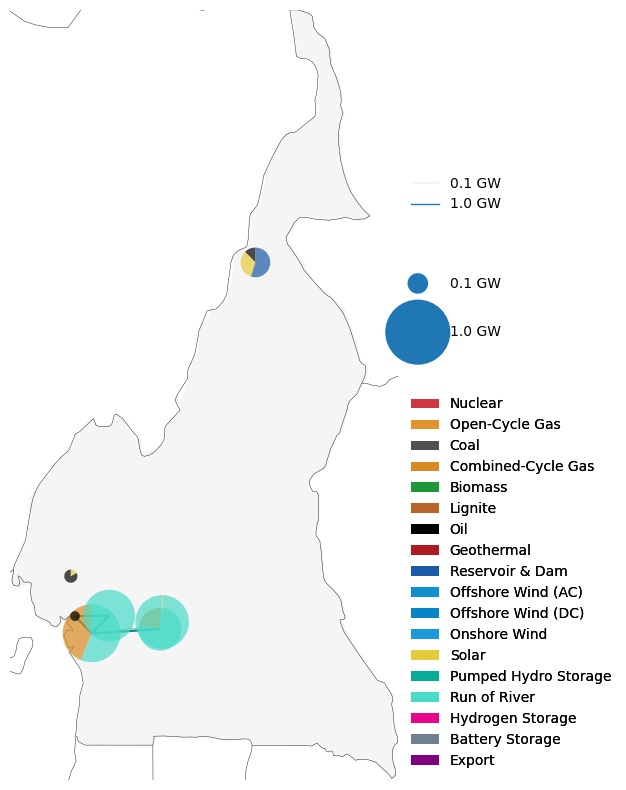

In [1578]:
# Scale settings
bus_scale = 2e3 
line_scale = 1e3

# Legend settings
bus_sizes = [100, 1000]  # in MW
line_sizes = [100, 1000]  # in MW

n.carriers.drop("Load", inplace=True)

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
gen = n.generators[(n.generators.carrier != "load") & (n.generators.carrier != "export")].groupby(["bus", "carrier"]).p_nom.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom.sum()
buses = pd.concat([gen, sto])

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links[n.links.carrier != "export"].p_nom_opt / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,    
)
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
fig.tight_layout()

Analyse the current generation capacity of the energy system - pie chart view

In [1579]:
generator_capacity_by_carrier

carrier
CCGT           276.000000
offwind-ac       0.000000
offwind-dc       0.000000
oil             51.380000
onwind           0.000000
ror           1303.000000
solar           49.524912
Name: p_nom, dtype: float64

Text(0.5, 1.0, 'Generator Capacity by Carrier')

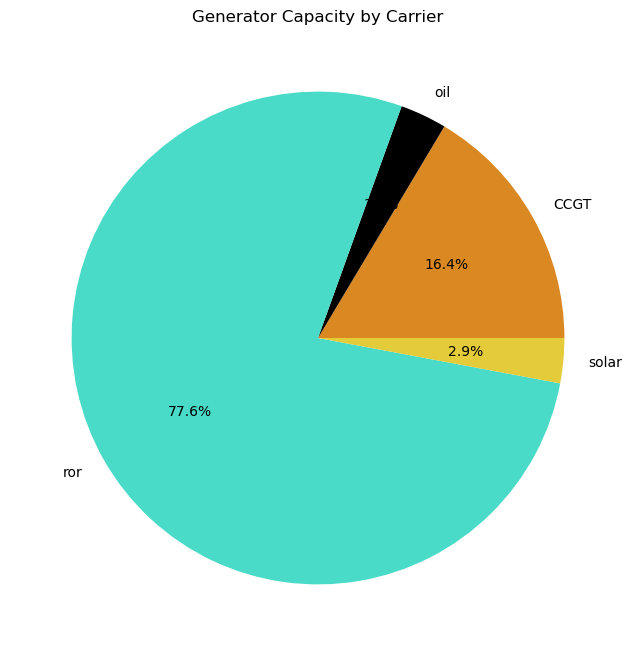

In [1580]:
generator_capacity_by_carrier = n.generators[(n.generators.carrier != "load") & (n.generators.carrier != "export")].groupby(["carrier"]).p_nom.sum()
plt.figure(figsize=(8, 8))
# Filter out carriers with zero capacity
filtered_capacity = generator_capacity_by_carrier[generator_capacity_by_carrier > 0]
# Get the corresponding colors
filtered_colors = n.carriers[n.carriers.index.isin(filtered_capacity.index)].color.reindex(filtered_capacity.index)
# Plot the pie chart
plt.pie(filtered_capacity, labels=filtered_capacity.index, autopct='%1.1f%%', colors=filtered_colors)
plt.title("Generator Capacity by Carrier")

Analyse the current gernation capacity of the energy system - tabular view

In [1581]:
generator_capacity_by_carrier/1e3 # in GW

carrier
CCGT          0.276000
offwind-ac    0.000000
offwind-dc    0.000000
oil           0.051380
onwind        0.000000
ror           1.303000
solar         0.049525
Name: p_nom, dtype: float64

Analyse the future capacity of the energy system - map view

/home/alex-charly/anaconda3/envs/pypsa-eur/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


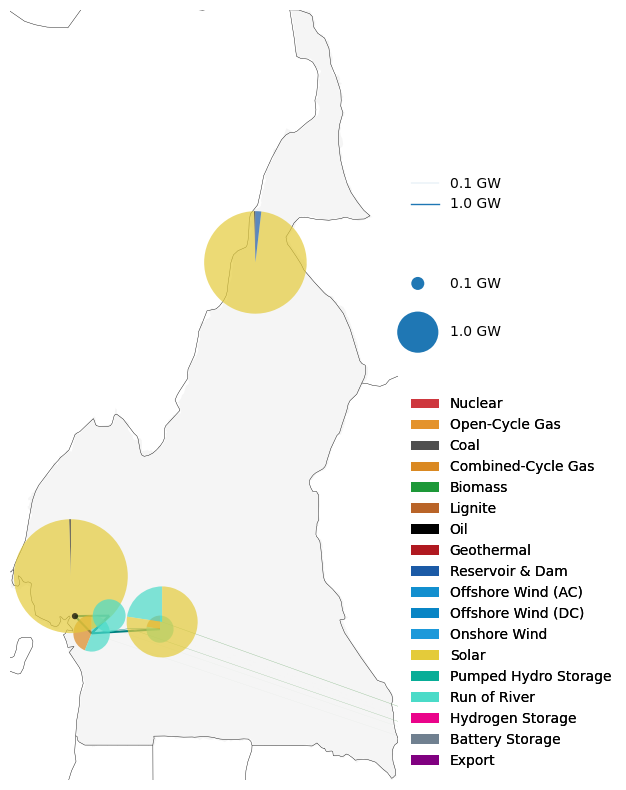

In [1582]:
bus_scale = 5e3 
line_scale = 1e3

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
gen = n.generators[(n.generators.carrier != "load") & (n.generators.carrier != "export")].groupby(["bus", "carrier"]).p_nom_opt.sum()
sto = n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum()
buses = pd.concat([gen, sto])

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,    
)
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)
add_legend_patches(
    ax,
    n.carriers.color,
    n.carriers.nice_name,
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
fig.tight_layout()

Calculate emissions of future energy system

In [1583]:
co2_emissions = pd.DataFrame(data=n.carriers[["co2_emissions", "nice_name"]]).set_index("nice_name").squeeze().rename_axis("carrier")

energy_production = n.statistics.energy_balance().Generator.droplevel(1).drop(["load", "export"], errors="ignore")

co2_emissions_technology = energy_production * co2_emissions.loc[energy_production.index]
co2_emissions_technology

carrier
Combined-Cycle Gas    59924.498957
Offshore Wind (AC)        0.000000
Offshore Wind (DC)        0.000000
Oil                    3845.562241
Onshore Wind              0.000000
Run of River              0.000000
Solar                     0.000000
dtype: float64

In [1584]:
co2_emissions_sum = co2_emissions_technology.sum()
co2_emissions_sum

63770.061197718

In [1585]:
n.global_constraints

,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,
CO2Limit,primary_energy,NaN,co2_emissions,<=,2056000.0,0.0


In [1586]:
# Step 1: Create the links_energy DataFrame with "carrier" and "bus0" columns
links_energy = n.links[["carrier", "bus0"]]

# Step 2: Filter only rows where "carrier" contains 'export'
links_energy = links_energy[links_energy["carrier"].str.contains("export", case=False, na=False)]

# Step 3: Calculate the energy sum for indices that contain 'export'
export_energy = n.links_t.p0.sum()
export_energy = export_energy[export_energy.index.str.contains("export", case=False, na=False)]

# Step 4: Map the energy sum to the correct rows in links_energy based on the index
links_energy["energy"] = links_energy.index.map(export_energy)

# Step 5: Group by "bus0" and "carrier" and sum the "energy" values
links_energy_grouped = links_energy.groupby(["bus0", "carrier"], as_index=False)["energy"].sum()

# Display the result
links_energy_grouped


,bus0,carrier,energy
0,1,export,1018.136582
1,12,export,315128.736156
2,18,export,11267.321677
3,19,export,181.569360
4,25,export,566350.323944
5,26,export,4905.403429
6,3,export,68.177938
7,6,export,1080.330613
8,Electricity export bus,export,0.000000


In [1587]:
links_energy_grouped.energy.sum()

899999.9996995205

/home/alex-charly/anaconda3/envs/pypsa-eur/lib/python3.12/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


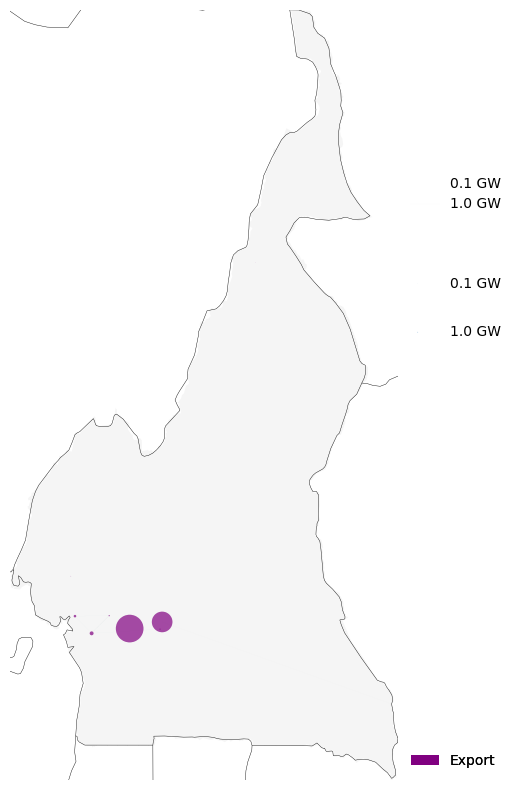

In [1604]:
# Scale settings
bus_scale = 0.1e8
line_scale = 3e5

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={"projection": ccrs.EqualEarth(n.buses.x.mean())})
export = links_energy_grouped[links_energy_grouped.carrier == "export"].groupby(["bus0", "carrier"]).energy.sum()
buses = pd.concat([export])

with plt.rc_context({"patch.linewidth": 0.}):
    n.plot(
        bus_sizes=buses / bus_scale,
        bus_alpha=0.7,
        line_widths=n.lines.s_nom_opt / line_scale,
        link_widths=n.links.p_nom_opt / line_scale,
        line_colors="teal",
        ax=ax,
        margin=0.2,
        color_geomap=None,
    )
regions_onshore.plot(
    ax=ax,
    facecolor="whitesmoke",
    edgecolor="white",
    aspect="equal",
    transform=ccrs.PlateCarree(),
    linewidth=0,
)
ax.set_extent(regions_onshore.total_bounds[[0, 2, 1, 3]])
legend_kwargs = {"loc": "upper left", "frameon": False}
legend_circles_dict = {"bbox_to_anchor": (1, 0.67), "labelspacing": 2.5, **legend_kwargs}

add_legend_circles(
    ax,
    [s / bus_scale for s in bus_sizes],
    [f"{s / 1000} GW" for s in bus_sizes],
    legend_kw=legend_circles_dict,    
)
add_legend_lines(
    ax,
    [s / line_scale for s in line_sizes],
    [f"{s / 1000} GW" for s in line_sizes],
    legend_kw={"bbox_to_anchor": (1, 0.8), **legend_kwargs},
)
add_legend_patches(
    ax,
    n.carriers.color.loc["export"],
    n.carriers.nice_name.loc["export"],
    legend_kw={"bbox_to_anchor": (1, 0), **legend_kwargs, "loc":"lower left"},
)
fig.tight_layout()

Analys the future generation capacity expansion of the energy system - bar chart

<Axes: title={'center': 'Generator capacity expansion in GW'}, xlabel='carrier'>

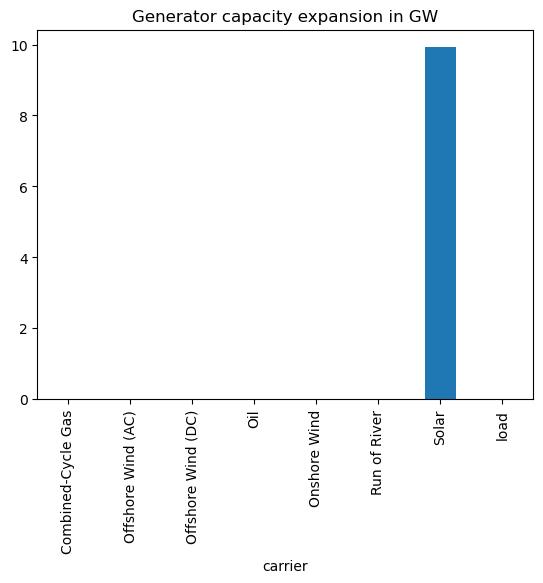

In [1589]:
generation_capacity_expansion = n.statistics.optimal_capacity(comps=["Generator"]).droplevel(0).div(1e3)-n.statistics.installed_capacity(comps=["Generator"]).droplevel(0).div(1e3)
generation_capacity_expansion.plot.bar(title="Generator capacity expansion in GW")

Plot the future generation capacity expansion of the energy system - tabular chart

In [1590]:
generation_capacity_expansion # In GW

carrier
Combined-Cycle Gas    0.000000
Offshore Wind (AC)         NaN
Offshore Wind (DC)         NaN
Oil                   0.000000
Onshore Wind               NaN
Run of River          0.000000
Solar                 9.920417
load                  0.000000
dtype: float64

Analyse the future energy generation of the energy system - bar chart view

In [1591]:
# Color for figure
n.carriers.loc["H2 electrolysis", "nice_name"] = "H2 Electrolysis"
n.carriers.loc["H2 electrolysis", "color"] = "#ea048a"
n.carriers.loc["H2 fuel cell", "nice_name"] = "H2 Fuel Cell"
n.carriers.loc["H2 fuel cell", "color"] = "#ea048a"
n.carriers.loc["battery charger", "nice_name"] = "Battery Charger"
n.carriers.loc["battery charger", "color"] = rgb_to_hex(140,191,62)
n.carriers.loc["battery discharger", "nice_name"] = "Battery Discharger"
n.carriers.loc["battery discharger", "color"] = rgb_to_hex(140,191,62)
n.carriers.loc["load", "nice_name"] = "Load"
n.carriers.loc["load", "color"] = "#8b0000"

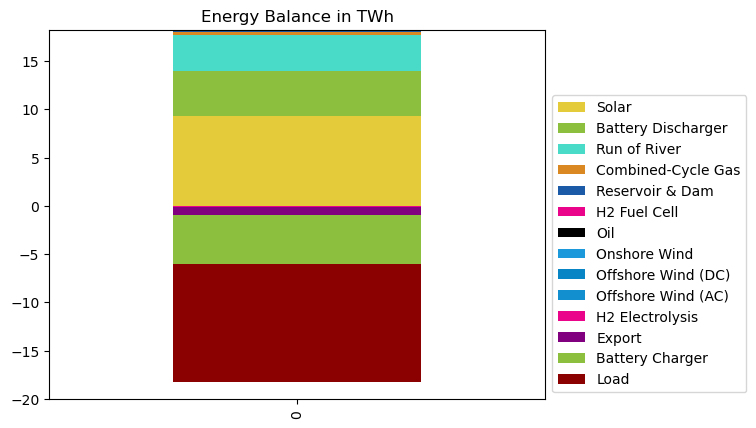

In [1592]:
# Set the index of n.carriers to nice_name
color_setting = n.carriers.set_index('nice_name')

# Calculate energy balance
energy_balance = n.statistics.energy_balance().loc[:, :, "AC"].groupby("carrier").sum().sort_values(ascending=False).div(1e6).to_frame().T
energy_balance.drop(columns=["Load"], inplace=True)
energy_balance.rename(columns={'-': 'Load'}, inplace=True)

# Get the colors for the carriers
colors = color_setting.loc[energy_balance.columns, 'color']

# Plot the bar chart with colors
fig, ax = plt.subplots()
energy_balance.plot.bar(stacked=True, ax=ax, title="Energy Balance in TWh", color=colors)

# Adjust legend
ax.legend(bbox_to_anchor=(1, 0), loc="lower left", title=None, ncol=1)

plt.show()


Analyse the future energy generation of the energy system - tabular view

In [1593]:
n.statistics.energy_balance()/1e6 # In TWh

component    carrier             bus_carrier     
Link         Battery Charger     AC                 -5.021673e+00
                                 Battery Storage     4.820806e+00
             Battery Discharger  AC                  4.627973e+00
                                 Battery Storage    -4.820806e+00
             Export              AC                 -9.000000e-01
                                 Export              9.000000e-01
             H2 Electrolysis     AC                 -1.009736e-01
                                 Hydrogen Storage    6.277530e-02
             H2 Fuel Cell        AC                  3.138765e-02
                                 Hydrogen Storage   -6.277530e-02
Generator    Combined-Cycle Gas  AC                  3.026490e-01
             Load                AC                  6.700000e-10
                                 Battery Storage     6.900000e-10
                                 Export              9.000000e-11
                          

## Analyse pv and wind potential - map view

In [1594]:
solar = xr.open_dataset(solar_path)
wind = xr.open_dataset(onwind_path)

def plot_voronoi(n, carrier, voronoi, cmap, projection, title=None, filename=None):
    g = n.generators.loc[n.generators.carrier == carrier]
    br = gpd.read_file(f"resources/{scenario_name}/bus_regions/regions_{voronoi}.geojson").set_index("name")
    br_area = br.to_crs("ESRI:54009")
    br_area = br_area.geometry.area * 1e-6
    br["p_nom_max"] = g.groupby("bus").sum().p_nom_max / br_area

    fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={"projection": projection})
    plt.rcParams.update({"font.size": 10})
    br.plot(
        ax=ax,
        column="p_nom_max",
        transform=ccrs.PlateCarree(),
        linewidth=0.25,
        edgecolor="k",
        cmap=cmap,
        vmin=0,
        vmax=br["p_nom_max"].max(),
        legend=True,
        legend_kwds={"label": r"potential density"},
    )
    ax.coastlines()
    ax.add_feature(cartopy.feature.BORDERS.with_scale("110m"))
    ax.set_extent(country_coordinates, crs=ccrs.PlateCarree()) 
    
    if title is not None:
        plt.title(title)

Plot pv energy potential

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20'],
      dtype='object', name='name')
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20'],
      dtype='object', name='name')
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20'],
      dtype='object', name='name')
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20'],
      dtype='object', name='name')
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20'],
      dtype='object', name='name')
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20'],
      dtype='object', name='name')
Inde

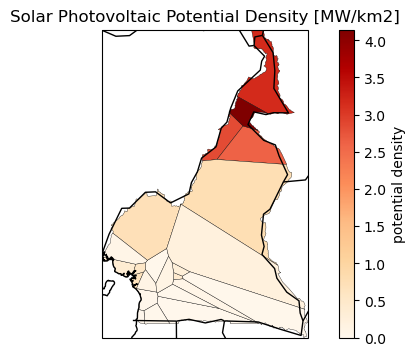

In [1595]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plot_voronoi(
    pypsa.Network(network_path),
    "solar",
    "onshore",
    "OrRd",
    ccrs.PlateCarree(),
    title="Solar Photovoltaic Potential Density [MW/km2]",
)
warnings.simplefilter(action='default', category=FutureWarning)

Plot wind energy potential

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20'],
      dtype='object', name='name')
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20'],
      dtype='object', name='name')
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20'],
      dtype='object', name='name')
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20'],
      dtype='object', name='name')
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20'],
      dtype='object', name='name')
Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20'],
      dtype='object', name='name')
Inde

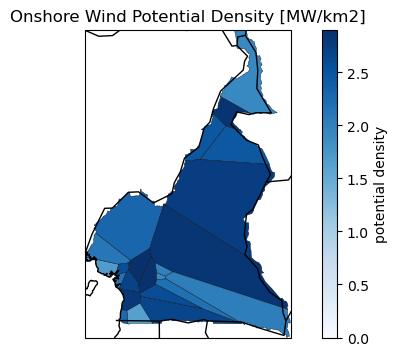

In [1596]:
warnings.simplefilter(action='ignore', category=FutureWarning)
plot_voronoi(
    pypsa.Network(network_path),
    "onwind",
    "onshore",
    "Blues",
    ccrs.PlateCarree(),
    title="Onshore Wind Potential Density [MW/km2]",
)
warnings.simplefilter(action='default', category=FutureWarning)

Levelized cost of electricity

In [1597]:
# Calculation levelzied cost of electricity in €/MWh based on overall costs and electricity generation
# n.statistics.market_value() ?
lcoe = n.objective/n.statistics.energy_balance().Generator.sum()
lcoe 

57.51426287547362

In [1598]:
# Calculation levelzied cost of electricity in €/MWh based on overall costs and electricity demand
lcoe = n.objective/n.statistics.energy_balance().Load.sum()*(-1)
lcoe 

58.87244625490221

Average THG value

In [1601]:
THG_Strom = co2_emissions_technology.sum()/n.statistics.energy_balance().Generator.sum()
THG_Strom #t CO2/MWh Strom bzw. kg CO2/kWh Strom
THG_H2 = THG_Strom/0.65 #Wirkungsgrad Elektrolyseur
THG_H2 #kg CO2/kWh H2
THG_H2 = THG_H2*33.33 #kWh/kg
THG_H2 # kg CO2/kg H2

0.24383111952946887